In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nvidia_model import load_multi_dataset,filter_dataset,filter_dataset_2nd_pass
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
## Load a model
from keras.models import load_model

trained_model=load_model("model_r_v6.h5")

In [26]:
train_dataset_folder = [("track1_new_1/",1),
                        ("track1_rec_1/",1),
                        ("track1_rec_2",1),
                        ("track1_rec_3",1),
                        ("track2_7",1),
                        ("track2_8",1),
                        ("track2_9",1),
                        ("track2_rec_5",1),
                        ("track2_rec_6",1),
                        ("track2_rec_8",1),
                        ("track2_rec_7",1)]

In [27]:
log_df=load_multi_dataset(train_dataset_folder)
filtered_log_df=filter_dataset(log_df,portion=200)
filtered_log_df=filter_dataset_2nd_pass(filtered_log_df,portion=5)

In [28]:
from sklearn.utils import shuffle
def generator(samples, batch_size=32, shuffle_samples=True,cam_index=0):
    num_samples = len(samples)

    while True:  # Loop forever so the generator never terminates
        if shuffle_samples:
            print("reshuffled")
            samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):

            batch_samples = samples.iloc[offset:min(offset + batch_size, num_samples), cam_index]

            images = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(batch_sample)
                center_image=cv2.resize(center_image,dsize=(0,0),fx=0.5,fy=0.5)
                images.append(center_image)
                

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = samples.iloc[offset:min(offset + batch_size, num_samples), 3]

            yield X_train, y_train

Get predicted label of center camera

In [29]:
batch_size=128
pred_gen=generator(filtered_log_df,shuffle_samples=False,batch_size=batch_size)
pred=trained_model.predict_generator(pred_gen,val_samples=filtered_log_df.shape[0])

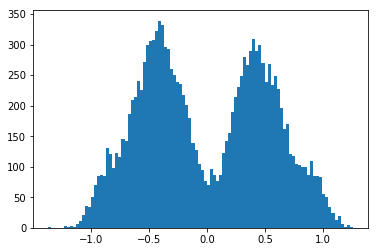

In [30]:
plt.hist(pred,bins=100)
plt.show()

Get "true" labels

In [31]:
true_gen=generator(filtered_log_df,shuffle_samples=False,batch_size=batch_size)
y_train=[]
for offset in range(0,filtered_log_df.shape[0],batch_size):
    y_train=np.concatenate([y_train,next(true_gen)[1].values])

In [32]:
assert pred.shape[0]==y_train.shape[0]

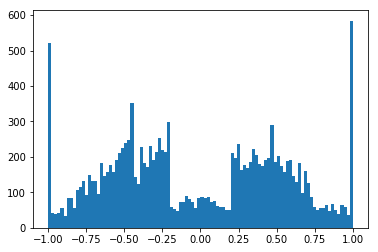

In [33]:
plt.hist(y_train,bins=100)
plt.show()

### Compare the predicted steering vs. true steering angles

In [34]:
from scipy.stats import linregress
def fit_data(x_data,y_data):
    slope, intercept, r_value, p_value, std_err=linregress(x_data.ravel(),y_data.ravel())
    x=np.linspace(np.min(x_data),np.max(x_data),num=20)
    plt.plot(x_data,y_data,'.')
    plt.plot(x,x*slope+intercept)
    print("slope:%s"%slope)
    print("intercept:%s"%intercept)
    print("r_value:%s"%r_value)

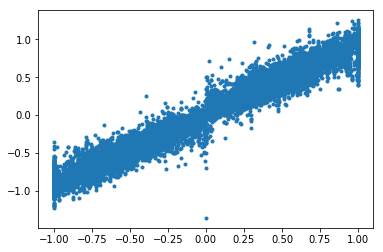

In [35]:
plt.plot(y_train,pred,'.')

slope:0.930718060068
intercept:0.0130955157407
r_value:0.97680186887


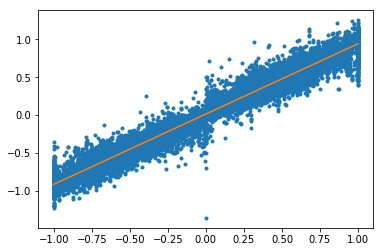

In [36]:
fit_data(y_train,pred)

## Find the relation between the left and right camera images

In [37]:
pred_gen=generator(filtered_log_df,shuffle_samples=False,batch_size=batch_size,cam_index=1)
left_pred=trained_model.predict_generator(pred_gen,val_samples=filtered_log_df.shape[0])

slope:0.83921140837
intercept:0.0650800563125
r_value:0.929089964497


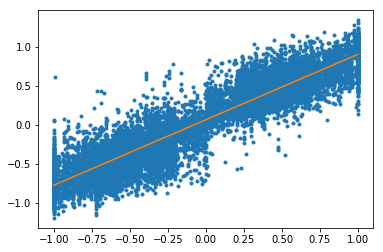

In [38]:
fit_data(y_train,left_pred)

slope:0.677501426482
intercept:0.167761720526
r_value:0.720644399779


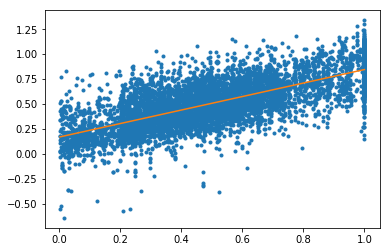

In [39]:
fit_data(y_train[y_train>0],left_pred[y_train>0])

slope:0.674770699812
intercept:-0.040351412743
r_value:0.587863188651


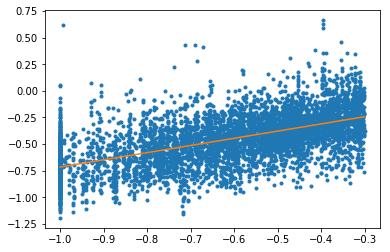

In [47]:
fit_data(y_train[y_train<-0.3],left_pred[y_train<-0.3])

In [41]:
pred_gen=generator(filtered_log_df,shuffle_samples=False,batch_size=batch_size,cam_index=2)
right_pred=trained_model.predict_generator(pred_gen,val_samples=filtered_log_df.shape[0])

slope:0.850017381398
intercept:-0.0777218078162
r_value:0.922759275813


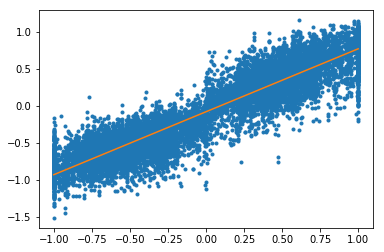

In [42]:
fit_data(y_train,right_pred)

slope:0.710326246855
intercept:0.0183113471585
r_value:0.666808181141


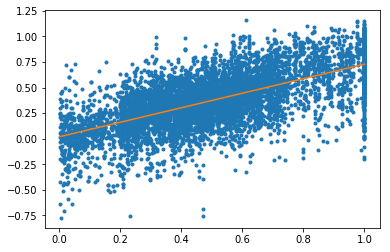

In [43]:
fit_data(y_train[y_train>0],right_pred[y_train>0])

slope:0.623462700669
intercept:-0.214237090049
r_value:0.676259611646


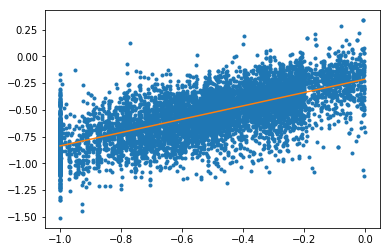

In [44]:
fit_data(y_train[y_train<0],right_pred[y_train<0])

0.912720800355
-0.089685439323


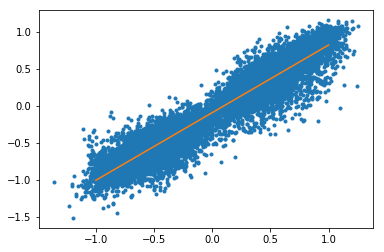

In [45]:
slope, intercept, r_value, p_value, std_err=linregress(pred.ravel(),right_pred.ravel())
x=np.linspace(-1,1,num=20)
plt.plot(pred,right_pred,'.')
plt.plot(x,x*slope+intercept)
print(slope)
print(intercept)

0.902979636801
0.053280253291


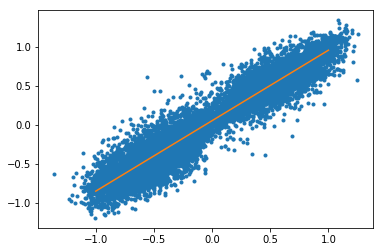

In [46]:
slope, intercept, r_value, p_value, std_err=linregress(pred.ravel(),left_pred.ravel())
x=np.linspace(-1,1,num=20)
plt.plot(pred,left_pred,'.')
plt.plot(x,x*slope+intercept)
print(slope)
print(intercept)